In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import time
import math
import random
import copy
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import datasets, layers, models
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D?
from keras.utils.np_utils import to_categorical
from sklearn.cluster import KMeans, AgglomerativeClustering
from tensorflow.keras.datasets import cifar10
from keras.datasets import fashion_mnist 
from sklearn.metrics import silhouette_samples, silhouette_score

mod = sys.modules[__name__]

In [2]:
def distribution_check(dataset):
        #분포가 다름;
    one,two,three,four,five,six,seven,eight,nine,ten=0,0,0,0,0,0,0,0,0,0

    for i in range(len(dataset)):
        if(dataset[i]==1):    one+=1
        elif(dataset[i]==2):  two+=1
        elif(dataset[i]==3):  three+=1
        elif(dataset[i]==4):  four+=1
        elif(dataset[i]==5):  five+=1
        elif(dataset[i]==6):  six+=1
        elif(dataset[i]==7):  seven+=1
        elif(dataset[i]==8):  eight+=1
        elif(dataset[i]==9):  nine+=1
        elif(dataset[i]==0):  ten+=1

    #print(one,two,three,four,five,six,seven,eight,nine,ten)
    #print("Sum : ", one+two+three+four+five+six+seven+eight+nine+ten)
    sums = one+two+three+four+five+six+seven+eight+nine+ten
    for_graph=[one,two,three,four,five,six,seven,eight,nine,ten]
    
    return for_graph, sums

def local_model_generate(model): #초기 모델 생성
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    
    return model

def step_function(data):
    if data > 0:
        return 1
    else:
        return 0

def sigmoid(data):
    return 1/(1+np.exp(-data))

def relu(data):
    return np.maximum(0,data)

def random_check(local, train_data, test_data):
    check_distribution_train_data, check_distribution_test_data, y_train_tmp, y_test_tmp = [], [], [], []
    sum1, sum2, data_index = 0,0, np.arange(0,10)

    for j in range(len(train_data)):
        y_train_tmp.append(np.argmax(train_data[j])) #원핫인코딩에서 다시 0~9 레이블로 변환

    for j in range(len(test_data)):
        y_test_tmp.append(np.argmax(test_data[j]))

    check_distribution_train_data, sum_train = distribution_check(y_train_tmp) #한번 밖에 실행 못함
    check_distribution_test_data, sum_test = distribution_check(y_test_tmp)
    sum1, sum2 = (sum1 + sum_train), (sum2 + sum_test)
    
    return check_distribution_train_data, check_distribution_test_data


In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print(x_train.shape, x_test.shape)
num_train, num_test = len(x_train),  len(x_test) 

(60000, 28, 28) (10000, 28, 28)


In [4]:
local = 21 # 10개 : 1~10 => 11은 포함 안됨
batch_size, epochs = 32, 4
global_epoch = 0
num_layers = 8

In [5]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

print("Step 1 x_train shape:", x_train.shape)

x_train = x_train.reshape((num_train, 28, 28, 1))
x_test = x_test.reshape((num_test, 28, 28, 1))

print("Step 2 x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")
# convert class vectors to binary class matrices => one hot encoding 지금은 [3,6,2,5,4,8..] 섞여있음 

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Step 1 x_train shape: (60000, 28, 28)
Step 2 x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


# 아래는 같은 양 만큼 나눠서 학습 (1/10) - IID

In [6]:
#랜덤 비복원추출, 동등하게 10% 씩 =  로컬 데이터 추출 ------------------------------------------------------------------------------
'''
global_epoch = 0

print(global_epoch, " 번째 global_epoch 데이터 랜덤하게 준비!!")

for i in range(1,local): #데이터 변수 선언, 빈 리스트로 초기화
    globals()['L{}_x_train'.format(i)], globals()['L{}_x_test'.format(i)] = [],[]  
    globals()['L{}_y_train'.format(i)], globals()['L{}_y_test'.format(i)] = [],[]  

x_train_range = list(np.arange(0,len(x_train)))  #0~59,999
x_test_range = list(np.arange(0,len(x_test)))  #0~9,999

for n in range(1,local): #Data_x_train_range, 잘 작동함 => 확인 완료
    tmp, tmp2 = [], []
    tmp = random.sample(list(x_train_range), int(num_train/(local-1)))  #1/10개 만큼 인덱스 랜덤 비복원 추출 => 랜덤으로 해야함
    tmp2 = random.sample(list(x_test_range), int(num_test/(local-1)))

    for i in range(len(tmp)):
        globals()['L{}_x_train'.format(n)].append(x_train[tmp[i]])  #n번째 Cluster에 분할한 실제 x_train 데이터 저장
        globals()['L{}_y_train'.format(n)].append(y_train[tmp[i]]) 
        x_train_range.remove(tmp[i])  #랜덤 하게 뽑힌 원소 6000개 추출했으니 안에서 삭제

    for j in range(len(tmp2)):
        globals()['L{}_x_test'.format(n)].append(x_test[tmp2[j]])
        globals()['L{}_y_test'.format(n)].append(y_test[tmp2[j]])
        x_test_range.remove(tmp2[j])  #랜덤 하게 뽑힌 원소 6000개 추출했으니 안에서 삭제

print("check=>: should be 0 == ", len(x_train_range))  #원소 하나도 없어야 함. 확인.

print(global_epoch, " 번째 global_epoch 데이터 랜덤 준비완료!!")
'''

'\nglobal_epoch = 0\n\nprint(global_epoch, " 번째 global_epoch 데이터 랜덤하게 준비!!")\n\nfor i in range(1,local): #데이터 변수 선언, 빈 리스트로 초기화\n    globals()[\'L{}_x_train\'.format(i)], globals()[\'L{}_x_test\'.format(i)] = [],[]  \n    globals()[\'L{}_y_train\'.format(i)], globals()[\'L{}_y_test\'.format(i)] = [],[]  \n\nx_train_range = list(np.arange(0,len(x_train)))  #0~59,999\nx_test_range = list(np.arange(0,len(x_test)))  #0~9,999\n\nfor n in range(1,local): #Data_x_train_range, 잘 작동함 => 확인 완료\n    tmp, tmp2 = [], []\n    tmp = random.sample(list(x_train_range), int(num_train/(local-1)))  #1/10개 만큼 인덱스 랜덤 비복원 추출 => 랜덤으로 해야함\n    tmp2 = random.sample(list(x_test_range), int(num_test/(local-1)))\n\n    for i in range(len(tmp)):\n        globals()[\'L{}_x_train\'.format(n)].append(x_train[tmp[i]])  #n번째 Cluster에 분할한 실제 x_train 데이터 저장\n        globals()[\'L{}_y_train\'.format(n)].append(y_train[tmp[i]]) \n        x_train_range.remove(tmp[i])  #랜덤 하게 뽑힌 원소 6000개 추출했으니 안에서 삭제\n\n    for j in range(len

# 아래는 랜덤으로 양 나눠서 학습 - Non-IID

In [7]:
#랜덤 비복원추출, 동등하게 10% 씩 =  로컬 데이터 추출 ------------------------------------------------------------------------------
'''
global_epoch = 0

print(global_epoch, " 번째 global_epoch 데이터 랜덤하게 준비!!")

for i in range(1,local): #데이터 변수 선언, 빈 리스트로 초기화
    globals()['L{}_x_train'.format(i)], globals()['L{}_x_test'.format(i)] = [],[]  
    globals()['L{}_y_train'.format(i)], globals()['L{}_y_test'.format(i)] = [],[]  


for n in range(1,local): #x_train_range, 잘 작동함 => 확인 완료

    x_train_range = list(np.arange(0,len(x_train)))  #0~59,999
    x_test_range = list(np.arange(0,len(x_test)))  #0~9,999

    tmp, tmp2 = [], []

    num_pick = random.randint(1,len(list(x_train_range)))
    num_pick2 = int(len(x_test_range)/local) #test 데이터는 원래대로 항상 일정한 비율로 주면 될듯 => 어느정도 분량 이상 있어야 함
    
    tmp = random.sample(list(x_train_range), num_pick)  #1/10개 만큼 인덱스 랜덤 비복원 추출 => 랜덤으로 해야함
    tmp2 = random.sample(list(x_test_range), num_pick2)

    for i in range(len(tmp)):
        globals()['L{}_x_train'.format(n)].append(x_train[tmp[i]])  #n번째 Cluster에 분할한 실제 x_train 데이터 저장
        globals()['L{}_y_train'.format(n)].append(y_train[tmp[i]]) 
        #x_train_range.remove(tmp[i])  #랜덤 하게 뽑힌 원소갯수들 추출했으니 안에서 삭제  => 오래걸림

    for j in range(len(tmp2)):
        globals()['L{}_x_test'.format(n)].append(x_test[tmp2[j]])
        globals()['L{}_y_test'.format(n)].append(y_test[tmp2[j]])
        #x_test_range.remove(tmp2[j])  #랜덤 하게 뽑힌 원소 1000개 추출했으니 안에서 삭제  => 오래걸림
    
    print("CHECK :", n," 번째 로컬 클라이언트 Number of Training sets : ", len(globals()['L{}_x_train'.format(n)]), "   Number of Training sets : ", len(globals()['L{}_x_test'.format(n)]))

print("check=>: should be 0 == ", len(x_train_range))  #원소 하나도 없어야 함. 확인.
print(global_epoch, " 번째 global_epoch 데이터 랜덤 준비완료!!")
'''

'\nglobal_epoch = 0\n\nprint(global_epoch, " 번째 global_epoch 데이터 랜덤하게 준비!!")\n\nfor i in range(1,local): #데이터 변수 선언, 빈 리스트로 초기화\n    globals()[\'L{}_x_train\'.format(i)], globals()[\'L{}_x_test\'.format(i)] = [],[]  \n    globals()[\'L{}_y_train\'.format(i)], globals()[\'L{}_y_test\'.format(i)] = [],[]  \n\n\nfor n in range(1,local): #x_train_range, 잘 작동함 => 확인 완료\n\n    x_train_range = list(np.arange(0,len(x_train)))  #0~59,999\n    x_test_range = list(np.arange(0,len(x_test)))  #0~9,999\n\n    tmp, tmp2 = [], []\n\n    num_pick = random.randint(1,len(list(x_train_range)))\n    num_pick2 = int(len(x_test_range)/local) #test 데이터는 원래대로 항상 일정한 비율로 주면 될듯 => 어느정도 분량 이상 있어야 함\n    \n    tmp = random.sample(list(x_train_range), num_pick)  #1/10개 만큼 인덱스 랜덤 비복원 추출 => 랜덤으로 해야함\n    tmp2 = random.sample(list(x_test_range), num_pick2)\n\n    for i in range(len(tmp)):\n        globals()[\'L{}_x_train\'.format(n)].append(x_train[tmp[i]])  #n번째 Cluster에 분할한 실제 x_train 데이터 저장\n        globals()[\'L{}

#시작

In [8]:
#랜덤 비복원추출, 동등하게 10% 씩 =  로컬 데이터 추출 ------------------------------------------------------------------------------

global_epoch = 0

local = 21

print(global_epoch, " 번째 global_epoch 데이터 랜덤하게 준비!!")

for i in range(1,local): #데이터 변수 선언, 빈 리스트로 초기화
    globals()['L{}_x_train'.format(i)], globals()['L{}_x_test'.format(i)] = [], []  
    globals()['L{}_y_train'.format(i)], globals()['L{}_y_test'.format(i)] = [], []  

x_train_range = list(np.arange(0,len(x_train)))  #0~59,999
x_test_range = list(np.arange(0,len(x_test)))  #0~9,999

for n in range(1,local): #Data_x_train_range, 잘 작동함 => 확인 완료
    tmp, tmp2 = [], []
    tmp = random.sample(list(x_train_range), int(num_train/(local-1)))  #1/10개 만큼 인덱스 랜덤 비복원 추출 => 랜덤으로 해야함
    tmp2 = random.sample(list(x_test_range), int(num_test/(local-1)))

    for i in range(len(tmp)):
        globals()['L{}_x_train'.format(n)].append(x_train[tmp[i]])  #n번째 Cluster에 분할한 실제 x_train 데이터 저장
        globals()['L{}_y_train'.format(n)].append(y_train[tmp[i]]) 
        #x_train_range.remove(tmp[i])  #랜덤 하게 뽑힌 원소 6000개 추출했으니 안에서 삭제 => 비복원 추출

    for j in range(len(tmp2)):
        globals()['L{}_x_test'.format(n)].append(x_test[tmp2[j]])
        globals()['L{}_y_test'.format(n)].append(y_test[tmp2[j]])
        #x_test_range.remove(tmp2[j])  #랜덤 하게 뽑힌 원소 6000개 추출했으니 안에서 삭제 => 비복원 추출

print("check=>: should be 0 == ", len(x_train_range))  #원소 하나도 없어야 함. 확인.

print(global_epoch, " 번째 global_epoch 데이터 랜덤 준비완료!!")

0  번째 global_epoch 데이터 랜덤하게 준비!!
check=>: should be 0 ==  60000
0  번째 global_epoch 데이터 랜덤 준비완료!!


In [9]:
#준비된 데이터 (IID / NON-IID) np.array로

local = 21

global_epoch = 0
FedAvg_ACC, FedAvg_LOSS, fedavg_acc, fedavg_loss, acc, loss = [], [], [], [], 0, 0
num_layers_list = [0,2,4,6,7]
label_list = []

VAR_final_list_w, VAR_final_list_b = [], []


for i in range(1,local):
    globals()['L{}_x_train'.format(i)] = np.array(globals()['L{}_x_train'.format(i)])
    globals()['L{}_x_test'.format(i)] = np.array(globals()['L{}_x_test'.format(i)])
    globals()['L{}_y_train'.format(i)] = np.array(globals()['L{}_y_train'.format(i)])
    globals()['L{}_y_test'.format(i)] = np.array(globals()['L{}_y_test'.format(i)])


print("\n\n",global_epoch, "번째 global epoch에서 로컬 클라이언트 학습시작!\n\n학습 중 ...\n")
now = time.time()

for i in range(1,local):
    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)] = models.Sequential()  ##!!!!!!! 이게 글로벌 epoch에서는 2번째 부터 들어가면 안됨
    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)] = local_model_generate(globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)])      # initialize 필요 => 모델 프레임 구축

    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].fit(globals()['L{}_x_train'.format(i)], globals()['L{}_y_train'.format(i)], batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)

    loss, acc = globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].evaluate(globals()['L{}_x_test'.format(i,global_epoch)], globals()['L{}_y_test'.format(i)], verbose=2)
    
    fedavg_acc.append(acc)  #acc 넣기
    fedavg_loss.append(loss)  #loss 넣기


print(global_epoch, "번째 global epoch 로컬 클라이언트 학습완료!,  Total Training time : ", time.time()-now,"\n\n")

# 로컬 모델들 학습 완료하였고 로컬모델에서 weight, bias 추출 -------------------------------------------------------------------------------------

for i in range(1, local):
    for layer_index in num_layers_list:
        w = globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].layers[layer_index].get_weights() #get_weights = w[0],b[1]로 구성

        globals()['L{}_layer{}_w_tmp'.format(i,layer_index)] = w      # 클러스터링 용도
        globals()['L{}_layer{}_w'.format(i,layer_index)] = w          # weight aggregation 용도
            
# 클러스터에 넣을 변수 선언

for layer_index in num_layers_list:

    globals()['layer{}_W_tmp'.format(layer_index)] = []
    globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = 0  #FedAvg 용도
    
    globals()['var_list_layer{}_w'.format(layer_index)] = []
    globals()['var_list_layer{}_b'.format(layer_index)] = []
  
    w_scaler = 0
    #------------------------------------------------FedAvg--------------------------------------------------------
    for i in range(1, local):
        globals()['var_list_layer{}_w'.format(layer_index)].append(np.var(globals()['L{}_layer{}_w'.format(i,layer_index)][0]))
        globals()['var_list_layer{}_b'.format(layer_index)].append(np.var(globals()['L{}_layer{}_w'.format(i,layer_index)][1]))
      
        w_scaler = len(globals()['L{}_x_train'.format(i)]) / 60000
        globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] + (np.array(globals()['L{}_layer{}_w'.format(i,layer_index)]) * w_scaler)
    
    globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = np.array(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)]) / (local-1)   #np.array로 변함
    
    VAR_final_list_w.append(globals()['var_list_layer{}_w'.format(layer_index)])
    VAR_final_list_b.append(globals()['var_list_layer{}_b'.format(layer_index)])
    
#---------------------------------------------------------메모리 삭제-------------------------------------------------------------------


FedAvg_ACC.append(fedavg_acc)
FedAvg_LOSS.append(fedavg_loss)

## G{}_num_clusters_in_layer{}_w 에 속하는 거 말고 삭제 = 메모리 낭비

# Weight, bias 합친 것
 # FedAvg                   :  G{}_w_layer
 # 일반 클러스터링          :  G{}_c{}_w_layer{}               클러스터 갯수 파악 : G{}_num_clusters_in_layer{}_w
 # Actiavtion + 클러스터링  :  G{}_c{}_w_layer{}_Act           클러스터 갯수 파악 : G{}_num_clusters_in_layer{}_w_c_a



 0 번째 global epoch에서 로컬 클라이언트 학습시작!

학습 중 ...

16/16 - 0s - loss: 0.6132 - accuracy: 0.7800
16/16 - 0s - loss: 0.6290 - accuracy: 0.7560
16/16 - 0s - loss: 0.5762 - accuracy: 0.7640
16/16 - 0s - loss: 0.5706 - accuracy: 0.7860
16/16 - 0s - loss: 0.5935 - accuracy: 0.8000
16/16 - 0s - loss: 0.6346 - accuracy: 0.7520
16/16 - 0s - loss: 0.6054 - accuracy: 0.7880
16/16 - 0s - loss: 0.6016 - accuracy: 0.7620
16/16 - 0s - loss: 0.6149 - accuracy: 0.7760
16/16 - 0s - loss: 0.6273 - accuracy: 0.7600
16/16 - 0s - loss: 0.7533 - accuracy: 0.7160
16/16 - 0s - loss: 0.5993 - accuracy: 0.7960
16/16 - 0s - loss: 0.5720 - accuracy: 0.7800
16/16 - 0s - loss: 0.5833 - accuracy: 0.7940
16/16 - 0s - loss: 0.5688 - accuracy: 0.7820
16/16 - 0s - loss: 0.5357 - accuracy: 0.7940
16/16 - 0s - loss: 0.5798 - accuracy: 0.8020
16/16 - 0s - loss: 0.6030 - accuracy: 0.7900
16/16 - 0s - loss: 0.6927 - accuracy: 0.7540
16/16 - 0s - loss: 0.6334 - accuracy: 0.7840
0 번째 global epoch 로컬 클라이언트 학습완료!,  Total Training t

<ipython-input-9-04786439ab09>:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] + (np.array(globals()['L{}_layer{}_w'.format(i,layer_index)]) * w_scaler)


In [10]:
local = 21

G_epoch = 21

for global_epoch in range(1, G_epoch):

    for layer_index in num_layers_list:
        for i in range(1, local):  #FedAvg
            globals()['FedAvg_L{}_iter{}_model'.format(i,global_epoch)] = globals()['FedAvg_L{}_iter{}_model'.format(i,global_epoch-1)]   #구조만 필요

            globals()['FedAvg_L{}_iter{}_model'.format(i,global_epoch)].layers[layer_index].set_weights(globals()['G{}_w_layer{}'.format(global_epoch-1, layer_index)])  #set_weights
        

    #----------------------------------------------------------------데이터 새로 준비----------------------------------------------------------------------------------
    print(global_epoch, " 번째 global_epoch 데이터 랜덤하게 준비!!")


    for i in range(1,local):
        globals()['L{}_x_train'.format(i)], globals()['L{}_x_test'.format(i)] = [], []
        globals()['L{}_y_train'.format(i)], globals()['L{}_y_test'.format(i)] = [], []  
        
    x_train_range = list(np.arange(0,len(x_train)))  #0~59,999
    x_test_range = list(np.arange(0,len(x_test)))  #0~9,999

    for n in range(1,local): #Data_x_train_range, 잘 작동함 => 확인 완료
        tmp, tmp2 = [], []
        tmp = random.sample(list(x_train_range), int(num_train/(local-1)))  #1/10개 만큼 인덱스 랜덤 비복원 추출 => 랜덤으로 해야함
        tmp2 = random.sample(list(x_test_range), int(num_test/(local-1)))

        for i in range(len(tmp)):
            globals()['L{}_x_train'.format(n)].append(x_train[tmp[i]])  #n번째 Cluster에 분할한 실제 x_train 데이터 저장
            globals()['L{}_y_train'.format(n)].append(y_train[tmp[i]]) 
            #x_train_range.remove(tmp[i])  #랜덤 하게 뽑힌 원소 6000개 추출했으니 안에서 삭제 = 복원추출

        for j in range(len(tmp2)):
            globals()['L{}_x_test'.format(n)].append(x_test[tmp2[j]])
            globals()['L{}_y_test'.format(n)].append(y_test[tmp2[j]])
            #x_test_range.remove(tmp2[j])  #랜덤 하게 뽑힌 원소 6000개 추출했으니 안에서 삭제

    for i in range(1,local):
        globals()['L{}_x_train'.format(i)] = np.array(globals()['L{}_x_train'.format(i)])
        globals()['L{}_x_test'.format(i)] = np.array(globals()['L{}_x_test'.format(i)])
        globals()['L{}_y_train'.format(i)] = np.array(globals()['L{}_y_train'.format(i)])
        globals()['L{}_y_test'.format(i)] = np.array(globals()['L{}_y_test'.format(i)])


    print(global_epoch, " 번째 global_epoch 데이터 랜덤 준비완료!!\n\n")

    print(global_epoch, " 번째 global epoch에서 로컬 클라이언트 들 학습시작!\n\n학습 중 ...\n")
    

    #-------------------------------------------------------------------여기가 핵심, 알고리즘 3개 따로 학습시켜야 함--------------------------------------------------------------------

    #======================================================================== FedAvg ========================================================================

    fedavg_acc, fedavg_loss, now = [],[], time.time()

    for i in range(1,local):
        # 아까 옮겨줘서 모델 그대로 compile, train 시키면 됨      
        globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

        globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].fit(globals()['L{}_x_train'.format(i)], globals()['L{}_y_train'.format(i)], batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)

        loss, acc = globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].evaluate(globals()['L{}_x_test'.format(i)], globals()['L{}_y_test'.format(i)], verbose=2)
        
        fedavg_acc.append(acc)  #acc 넣기
        fedavg_loss.append(loss)  #loss 넣기

    print("------------   ", global_epoch, " 번째 global epoch < FedAVG > 로컬 클라이언트 학습 완료!,  Total Training time : ", time.time()-now,"---------------------------\n\n")


# 로컬 모델들 학습 완료, 로컬모델에서 weight, bias 추출 -------------------------------------------------------------------------------------


    for i in range(1, local):        
        for layer_index in num_layers_list:
            globals()['L{}_layer{}_w_tmp'.format(i,layer_index)] = globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].layers[layer_index].get_weights() #get_weights = w[0],b[1]로 구성, FedAvg
            
    #------------------------------------------------FedAvg--------------------------------------------------------바로 Fedavg 시키기
    
    for layer_index in num_layers_list:
        globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = 0

        globals()['var_list_layer{}_w'.format(layer_index)] = []
        globals()['var_list_layer{}_b'.format(layer_index)] = []
        w_scaler = len(globals()['L{}_x_train'.format(i)]) / 60000
        
        for i in range(1, local):
            globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] + (np.array(globals()['L{}_layer{}_w_tmp'.format(i,layer_index)])*w_scaler)

        for i in range(1, local):
            globals()['var_list_layer{}_w'.format(layer_index)].append(np.var(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)][0]))            
            globals()['var_list_layer{}_b'.format(layer_index)].append(np.var(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)][1]))
            
          
        VAR_final_list_w.append(globals()['var_list_layer{}_w'.format(layer_index)])
        VAR_final_list_b.append(globals()['var_list_layer{}_b'.format(layer_index)])
    

    FedAvg_ACC.append(fedavg_acc)
    FedAvg_LOSS.append(fedavg_loss)

    print("\n\n====================================================== One Global Epoch =====================================================================\n\n")


1  번째 global_epoch 데이터 랜덤하게 준비!!
1  번째 global_epoch 데이터 랜덤 준비완료!!


1  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 2.3025 - accuracy: 0.1300
16/16 - 0s - loss: 2.3036 - accuracy: 0.0740
16/16 - 0s - loss: 2.3022 - accuracy: 0.0920
16/16 - 0s - loss: 2.3047 - accuracy: 0.0780
16/16 - 0s - loss: 2.3017 - accuracy: 0.1180
16/16 - 0s - loss: 2.3044 - accuracy: 0.0900
16/16 - 0s - loss: 2.3021 - accuracy: 0.0840
16/16 - 0s - loss: 2.3033 - accuracy: 0.1080
16/16 - 0s - loss: 1.0286 - accuracy: 0.6320
16/16 - 0s - loss: 2.3037 - accuracy: 0.0840
16/16 - 0s - loss: 2.3028 - accuracy: 0.0900
16/16 - 0s - loss: 2.3017 - accuracy: 0.1080
16/16 - 0s - loss: 2.3031 - accuracy: 0.1020
16/16 - 0s - loss: 2.3038 - accuracy: 0.0940
16/16 - 0s - loss: 2.3036 - accuracy: 0.0940
16/16 - 0s - loss: 2.3034 - accuracy: 0.1020
16/16 - 0s - loss: 2.3028 - accuracy: 0.1060
16/16 - 0s - loss: 2.3023 - accuracy: 0.1000
16/16 - 0s - loss: 2.3046 - accuracy: 0.0980
16/16 - 0s - loss: 1.0767 - 

<ipython-input-10-7c99d4a373ba>:89: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] + (np.array(globals()['L{}_layer{}_w_tmp'.format(i,layer_index)])*w_scaler)


2  번째 global_epoch 데이터 랜덤 준비완료!!


2  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 1.0351 - accuracy: 0.5760
16/16 - 0s - loss: 1.0369 - accuracy: 0.5800
16/16 - 0s - loss: 1.0132 - accuracy: 0.6220
16/16 - 0s - loss: 0.9912 - accuracy: 0.6080
16/16 - 0s - loss: 0.9628 - accuracy: 0.6040
16/16 - 0s - loss: 0.9321 - accuracy: 0.6260
16/16 - 0s - loss: 1.0274 - accuracy: 0.6060
16/16 - 0s - loss: 0.9339 - accuracy: 0.6240
16/16 - 0s - loss: 0.9355 - accuracy: 0.6440
16/16 - 0s - loss: 1.0614 - accuracy: 0.5820
16/16 - 0s - loss: 1.0951 - accuracy: 0.5700
16/16 - 0s - loss: 0.9968 - accuracy: 0.6040
16/16 - 0s - loss: 1.0433 - accuracy: 0.6260
16/16 - 0s - loss: 0.9330 - accuracy: 0.6200
16/16 - 0s - loss: 0.9734 - accuracy: 0.6340
16/16 - 0s - loss: 1.1017 - accuracy: 0.6040
16/16 - 0s - loss: 0.9396 - accuracy: 0.6160
16/16 - 0s - loss: 1.0848 - accuracy: 0.5900
16/16 - 0s - loss: 0.9705 - accuracy: 0.6200
16/16 - 0s - loss: 1.0553 - accuracy: 0.5780
------------    

16/16 - 0s - loss: 0.8626 - accuracy: 0.6940
16/16 - 0s - loss: 0.7696 - accuracy: 0.7340
16/16 - 0s - loss: 0.7697 - accuracy: 0.7400
16/16 - 0s - loss: 0.6621 - accuracy: 0.7520
16/16 - 0s - loss: 0.5969 - accuracy: 0.7760
16/16 - 0s - loss: 0.6881 - accuracy: 0.7440
16/16 - 0s - loss: 0.7320 - accuracy: 0.7100
16/16 - 0s - loss: 0.7333 - accuracy: 0.7260
16/16 - 0s - loss: 0.8024 - accuracy: 0.6840
16/16 - 0s - loss: 0.7320 - accuracy: 0.7240
16/16 - 0s - loss: 0.6813 - accuracy: 0.7560
16/16 - 0s - loss: 0.6882 - accuracy: 0.7380
------------    8  번째 global epoch < FedAVG > 로컬 클라이언트 학습 완료!,  Total Training time :  157.1809606552124 ---------------------------




====================================================== One Global Epoch =====================================================================


9  번째 global_epoch 데이터 랜덤하게 준비!!
9  번째 global_epoch 데이터 랜덤 준비완료!!


9  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 0.7103 - accuracy: 0.7320
16/16 - 0s - loss

16/16 - 0s - loss: 0.6824 - accuracy: 0.7680
16/16 - 0s - loss: 0.6263 - accuracy: 0.7820
16/16 - 0s - loss: 0.6387 - accuracy: 0.7640
------------    14  번째 global epoch < FedAVG > 로컬 클라이언트 학습 완료!,  Total Training time :  219.66633343696594 ---------------------------




====================================================== One Global Epoch =====================================================================


15  번째 global_epoch 데이터 랜덤하게 준비!!
15  번째 global_epoch 데이터 랜덤 준비완료!!


15  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

16/16 - 0s - loss: 0.6447 - accuracy: 0.7680
16/16 - 0s - loss: 0.6490 - accuracy: 0.7660
16/16 - 0s - loss: 0.6390 - accuracy: 0.7640
16/16 - 0s - loss: 0.6136 - accuracy: 0.7680
16/16 - 0s - loss: 0.6448 - accuracy: 0.7360
16/16 - 0s - loss: 0.6358 - accuracy: 0.7760
16/16 - 0s - loss: 0.6546 - accuracy: 0.7820
16/16 - 0s - loss: 0.6338 - accuracy: 0.7720
16/16 - 0s - loss: 0.7417 - accuracy: 0.7380
16/16 - 0s - loss: 0.6723 - accuracy: 0.7480
16/16 - 0s -

# Var 그래프 : 누적량이랑 변화량

Variance Accumulate Layer 0,2,4,6,7
--------------------------------------------------------------------------------------------------


Var Accumulate Weight
--------------------------------------
[1.4605095e-06, 1.0444583e-05, 0.0002689344, 0.00040026396, 0.000471727, 0.0005535443, 0.00071381807, 0.00091321033, 0.0010899758, 0.0012687355, 0.0014500741, 0.0017562144, 0.0020542375, 0.0025448706, 0.0031777273, 0.0040469035, 0.00492326, 0.005820556, 0.0065076575, 0.0071969545]
[4.7173341e-07, 4.7443937e-06, 0.00052239705, 0.00060785864, 0.0006254765, 0.0005939773, 0.0005975398, 0.00073588366, 0.00090356584, 0.001057436, 0.0012637042, 0.0015492012, 0.0018774898, 0.002286235, 0.0028284867, 0.0034439901, 0.004018449, 0.0045707896, 0.0050085983, 0.0054309377]
[3.03216e-07, 3.3930442e-06, 0.00058437843, 0.0008019158, 0.000936416, 0.0010957515, 0.0012687974, 0.0014566932, 0.0016707606, 0.0019089811, 0.0021567622, 0.0024373685, 0.0027032061, 0.0030018082, 0.0033143454, 0.0036497456, 0.003993486

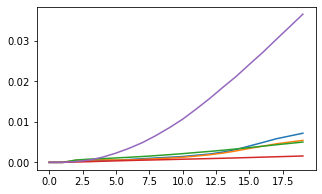

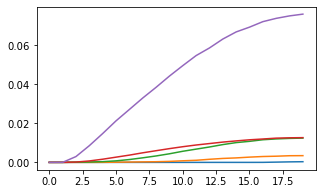

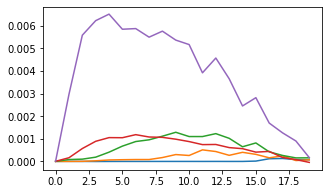

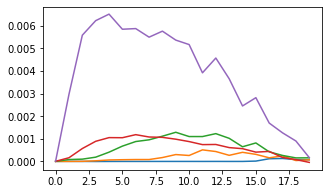

In [11]:
var_changes_L0_w, var_changes_L2_w, var_changes_L4_w, var_changes_L6_w, var_changes_L7_w = [], [], [], [], [] 
var_accumulate_L0_w, var_accumulate_L2_w, var_accumulate_L4_w, var_accumulate_L6_w, var_accumulate_L7_w = [], [], [], [], [] 

var_changes_L0_b, var_changes_L2_b, var_changes_L4_b, var_changes_L6_b, var_changes_L7_b = [], [], [], [], [] 
var_accumulate_L0_b, var_accumulate_L2_b, var_accumulate_L4_b, var_accumulate_L6_b, var_accumulate_L7_b = [], [], [], [], [] 


for global_epoch in range(G_epoch-1):
    for layer_index in num_layers_list:
        globals()['var_accumulate_L{}_w'.format(layer_index)].append(np.var(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)][0]))
        globals()['var_changes_L{}_w'.format(layer_index)].append(np.var(globals()['G{}_w_layer{}'.format(global_epoch+1, layer_index)][0]) - np.var(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)][0]))
        
        globals()['var_accumulate_L{}_b'.format(layer_index)].append(np.var(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)][1]))
        globals()['var_changes_L{}_b'.format(layer_index)].append(np.var(globals()['G{}_w_layer{}'.format(global_epoch+1, layer_index)][1]) - np.var(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)][1]))
        

print("Variance Accumulate Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------\n")

print("\nVar Accumulate Weight\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_accumulate_L{}_w'.format(j)])

print("\nVar Accumulate Bias\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_accumulate_L{}_b'.format(j)])

print("\n\nVariance Change Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------\n")

print("\nVar Changes Weight\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_accumulate_L{}_w'.format(j)])

print("\nVar Changes Bias\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_changes_L{}_b'.format(j)])



print("\nNow Check the graph\n")

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_accumulate_L{}_w'.format(j)])

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_accumulate_L{}_b'.format(j)])

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_changes_L{}_b'.format(j)])

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_changes_L{}_b'.format(j)])


# 글로벌 에폭 변하는 동안 레이어들간에 거리 그래프

Distance Layer 0,2,4,6,7
--------------------------------------------------------------------------------------------------
[0.0032142794, 0.03979163, 0.0058932644, 0.008038182, 0.0054285973, 0.0041764593, 0.0049286084, 0.0041846987, 0.004842518, 0.00490833, 0.0055507324, 0.0055983653, 0.0064714346, 0.0063215513, 0.0075520743, 0.007708743, 0.008722429, 0.00681333, 0.0065627214, 0.005936652]
[0.002977675, 0.029881898, 0.00986939, 0.0081889825, 0.012755199, 0.010765611, 0.010285783, 0.008467934, 0.0094837835, 0.013033535, 0.008688233, 0.010922417, 0.008671195, 0.00828774, 0.009130146, 0.008942777, 0.00731319, 0.0072077503, 0.0065722447, 0.0064082285]
[0.0037390462, 0.019536896, 0.012278463, 0.011512532, 0.0116045615, 0.011946723, 0.011862377, 0.011517421, 0.011282573, 0.010620417, 0.008923847, 0.008915251, 0.0081775775, 0.0078270435, 0.0070354696, 0.007796589, 0.0063008405, 0.0067662452, 0.0072049517, 0.005777752]
[0.0024625454, 0.007923041, 0.009560487, 0.008254187, 0.007060552, 0.00588

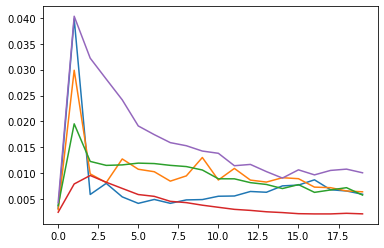

In [12]:
from scipy.spatial import distance

dist_0, dist_2, dist_4, dist_6, dist_7  = [], [], [], [], []

for global_epoch in range(G_epoch-1):
    for layer_index in num_layers_list:
        globals()['dist_{}'.format(layer_index)].append(np.mean(distance.euclidean(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)], globals()['G{}_w_layer{}'.format(global_epoch+1, layer_index)])))



print("Distance Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------")
print(dist_0)
print(dist_2)
print(dist_4)
print(dist_6)
print(dist_7, "\n\nCheck the graph\n")

plt.plot(dist_0)
plt.plot(dist_2)
plt.plot(dist_4)
plt.plot(dist_6)
plt.plot(dist_7)

plt.show()

In [13]:
#논문에 분산 얘기 할때 조심해야 할듯. 범위를 고려한다는 표현을 붙이던지 아님 거리의 평균 변화량이라고 표현하는 게 나을 듯

#중심점으로 수렴하는 것 = 거리 변화량 낮아짐

Average Acc and Loss Layer 0,2,4,6,7
--------------------------------------------------------------------------------------------------
[[0.7799999713897705, 0.7559999823570251, 0.7639999985694885, 0.7860000133514404, 0.800000011920929, 0.7519999742507935, 0.7879999876022339, 0.7620000243186951, 0.7760000228881836, 0.7599999904632568, 0.7160000205039978, 0.7960000038146973, 0.7799999713897705, 0.7940000295639038, 0.7820000052452087, 0.7940000295639038, 0.8019999861717224, 0.7900000214576721, 0.7540000081062317, 0.7839999794960022], [0.12999999523162842, 0.07400000095367432, 0.09200000017881393, 0.07800000160932541, 0.11800000071525574, 0.09000000357627869, 0.08399999886751175, 0.1080000028014183, 0.6320000290870667, 0.08399999886751175, 0.09000000357627869, 0.1080000028014183, 0.10199999809265137, 0.09399999678134918, 0.09399999678134918, 0.10199999809265137, 0.10599999874830246, 0.10000000149011612, 0.09799999743700027, 0.5659999847412109], [0.5759999752044678, 0.5799999833106995, 0.6

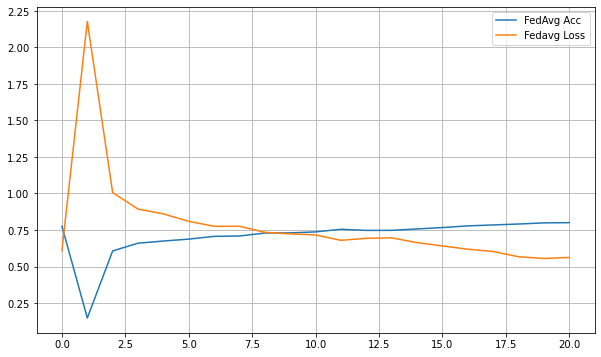

In [14]:
average_acc_list, average_loss_list = [], []


for i in range(len(FedAvg_ACC)):
    average_acc_list.append(np.mean(FedAvg_ACC[i]))
    average_loss_list.append(np.mean(FedAvg_LOSS[i]))
    

print("Average Acc and Loss Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------")
print(FedAvg_ACC)
print(FedAvg_LOSS)
print("\n\n Now Check the graph\n")

plt.figure(figsize=(10,6))
plt.plot(average_acc_list, label='FedAvg Acc')

plt.plot(average_loss_list, label='Fedavg Loss')

plt.grid(True)
plt.legend()
plt.show()
